# This nbook computes the trimmed mean and standard deviation of a feature across on training data non-ictal time windows and plots them. These values will be used for feature normalization. This function has been moved to  compute_ftr_mn_sd.py

In [83]:
import numpy as np
import numpy.matlib
import pandas as pd
import os
import pickle
import scipy.io as sio
import ieeg_funcs as ief
import dgFuncs as dg
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
import importlib
ief=importlib.reload(ief)

In [81]:
dir_dict=ief.get_path_dict()
print(dir_dict.keys())
print(dir_dict['ftrs_root'])
meta_dir=dir_dict['eu_meta']

dict_keys(['eu_root', 'onset_csv', 'pics', 'ieeg_root', 'eu_meta', 'ftrs_root', 'szr_ant_root'])
/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS


In [85]:
# Get list of files to be used for training
split_fname=os.path.join(meta_dir,'data_splits_FR_'+sub+'.pkl')
print('Loading %s' % split_fname)
split_dict=pickle.load(open(split_fname,'rb'))
split_dict.keys()
train_files=split_dict['train_files']

Loading /Users/davidgroppe/Dropbox/TWH_INFO/EU_METADATA/data_splits_FR_1096.pkl
['109600102_0000', '109600102_0001', '109600102_0002']


In [87]:
# Get list of feature files
sub='1096'
ftr_dir=os.path.join(dir_dict['ftrs_root'],'EU_MAG_LAG0',sub)
class_dir=os.path.join(dir_dict['ftrs_root'],'EU_SZR_CLASS',sub)

file_stems=list()
ftr_fnames=list()
for ftr_fname in os.listdir(ftr_dir):
    if ftr_fname.endswith('.npz'):
        tmp=ftr_fname.split('_')
        tmp_stem=tmp[0]+'_'+tmp[1]
        if tmp_stem in train_files:
            file_stems.append(tmp_stem)
            ftr_fnames.append(ftr_fname)
print('%d training files' % len(file_stems))

101 of training files


In [124]:
# Compute mean and sd of non-ictal points in training data
n_files=len(ftr_fnames)
print('%d training files' % n_files)
n_ftr=48
mns=np.zeros((n_ftr,n_files))
sds=np.zeros((n_ftr,n_files))
for f_ct, f_stem in enumerate(file_stems):
    # Load data
    ftr_dict=np.load(os.path.join(ftr_dir,ftr_fnames[f_ct]))
    #ftr_dict contains ['ftrs', 'time_wind_sec', 'ftr_list']
    
    if f_ct==0:
        # Get copy of feature labels to save with feature norms
        ftr_list=ftr_dict['ftr_list']
    
    # Load szr classes
    class_dict=np.load(os.path.join(class_dir,f_stem+'_szr_class.npz'))
    #Compute trimmed mean and sd
    for ftr_ct in range(n_ftr):
        mns[ftr_ct,f_ct], sds[ftr_ct,f_ct]=dg.trimmed_mn_sd(ftr_dict['ftrs'][ftr_ct, class_dict['szr_class']==0],0.15)
    # Compute regular mean and SD
#     mns[:,f_ct]=np.mean(ftr_dict['ftrs'][:,class_dict['szr_class']==0],axis=1)
#     sds[:,f_ct]=np.std(ftr_dict['ftrs'][:,class_dict['szr_class']==0],axis=1)

101 training files


In [113]:
# Get trimmed mean and SD (70% of data will be used for estimating mean & SD)
nrm_mn=np.zeros(n_ftr)
nrm_sd=np.zeros(n_ftr)
for ftr_ct in range(n_ftr):
    nrm_mn[ftr_ct], _=dg.trimmed_mn_sd(mns[ftr_ct,:],0)
    nrm_sd[ftr_ct], _=dg.trimmed_mn_sd(sds[ftr_ct,:],0)
    #nrm_mn[ftr_ct], nrm_sd[ftr_ct]=dg.trimmed_mn_sd(mns[ftr_ct,:],.15)

In [114]:
bro1=mns[0,:]-nrm_mn[0]
bro2=sds[0,:]-nrm_sd[0]
print(np.mean(bro1))
print(np.mean(bro2))

-3.96778319771e-14
-3.96778319771e-14


In [127]:
#SAVE nrm_mn and nrm_sd to disk for data preprocessing
out_fname=os.path.join(ftr_dir,'ftr_nrms.npz')
#out_fname=os.path.join(dir_dict['szr_ant_root'],'FTR_NRMS',sub+'_ftr_nrms.npz')
print('Saving feature norms to %s' % out_fname)
np.savez(out_fname, nrm_mn=nrm_mn, nrm_sd=nrm_sd, ftr_list=ftr_list, file_stems=file_stems)

Saving feature norms to /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/EU_MAG_LAG0/1096/ftr_nrms.npz


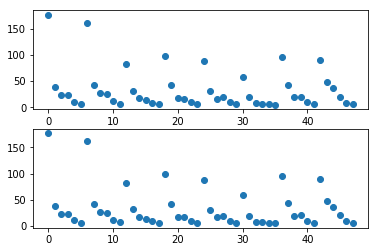

In [115]:
plt.figure(1)
plt.clf()
plt.subplot(2,1,1)
plt.plot(nrm_mn,'o')
plt.subplot(2,1,2)
plt.plot(nrm_sd,'o')

In [95]:
mnsZ=np.copy(mns)
# dg.trimmed_normalize(mnsZ,.2)
sdsZ=np.copy(sds)
# dg.trimmed_normalize(sdsZ,.2);

48 dimensions
101 observations
48 dimensions
101 observations


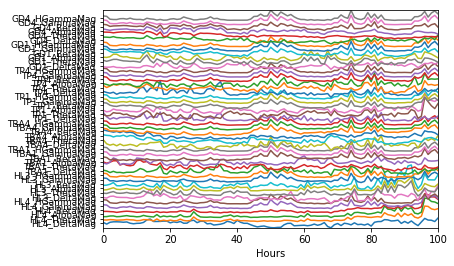

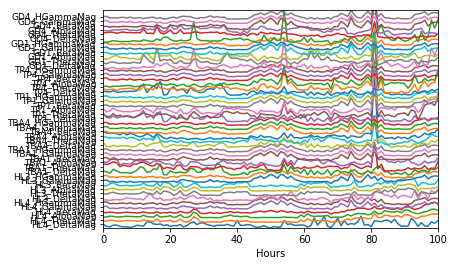

In [96]:
plt.figure(1)
plt.clf()
ief.strat_plot(mnsZ,ftr_dict['ftr_list'],fig_id=1, show_chan_ids=None, h_offset=4)
plt.xlabel('Hours')

plt.figure(2)
plt.clf()
ief.strat_plot(sdsZ,ftr_dict['ftr_list'],fig_id=2, show_chan_ids=None, h_offset=4)
plt.xlabel('Hours')

(0, 100)

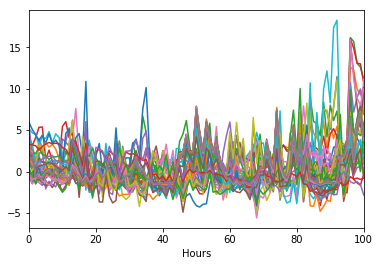

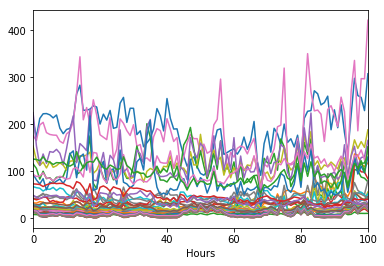

In [97]:
plt.figure(1)
plt.clf()
plt.plot(mnsZ.T);
plt.xlabel('Hours')
plt.xlim([0,n_files-1])

plt.figure(2)
plt.clf()
plt.plot(mns.T);
#plt.plot(sdsZ.T);
plt.xlabel('Hours')
plt.xlim([0,n_files-1])

(0, 100)

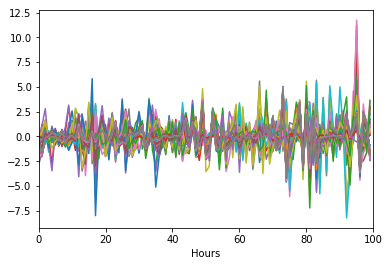

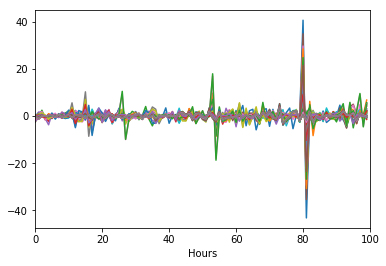

In [94]:
plt.figure(1)
plt.clf()
plt.plot(np.diff(mnsZ).T);
plt.xlabel('Hours')
plt.xlim([0,n_files-1])

plt.figure(2)
plt.clf()
plt.plot(np.diff(sdsZ).T);
plt.xlabel('Hours')
plt.xlim([0,n_files-1])

In [21]:
print(ftr_dict.keys())
print(class_dict.keys())

['ftrs', 'time_wind_sec', 'ftr_list']
['szr_class', 'time_wind_sec', 'wind_len', 'wind_step']


In [34]:
np.std?

In [22]:
bro=class_dict['szr_class']
bro.shape

(35437,)

In [27]:
sis=bro[bro==0]

In [28]:
np.unique(sis)

array([0], dtype=int8)

In [26]:
np.unique(bro)

array([0], dtype=int8)

In [29]:
sis.shape

(35437,)